In [7]:
import json
from whoosh.scoring import BM25F
from SearchEngine.word2vec.word2vec_model import Word2VecModel
from SearchEngine.sentiment.sentiment_model import SentimentModel, ReviewSentimentModel
from SearchEngine.sentiment.reviews_index import ReviewsIndex

import seaborn as sns
import pandas as pd

with open('queries.json') as f:
    queries = json.load(f)

# Models that need to be tested.
models = [
	(BM25F(), "BM25F"),
 	(Word2VecModel(), "Word2Vec"),
	(SentimentModel(ReviewsIndex()), "Sentiment Model"),
	(ReviewSentimentModel(ReviewsIndex()), "Review Sentiment Model")
]

### Showing all the available queries

In [8]:
indexes, uin = [i for i in range(len(queries))], [k["UIN"] for k in queries]
print('ID \t UIN')
print('\n'.join([f"{x[0]} \t {x[1]}" for x in list(zip(indexes, uin))]))

ID 	 UIN
0 	 I want to cook some delicious blueberries muffins
1 	 I want to surprise my family by cooking a crispy fish and chips, but i have not much time to prepare it
2 	 I went to my neighbor's house for lunch and they served me some amazing garlic bread, i want to make it too! Over 4 stars rating.
3 	 I love spicy food and I'd like to find an easy but outstanding recipe for spicy hot wings. Max 10 ingredients and only recipes from the 2000's
4 	 I have a date tonight and I want to surprise my fiancÃ©e with some elaborated and tasteful mexican recipe. Minimum 10 ingredients. Oh, and he's vegetarian
5 	 Yesterday I burned my tongue, I want to cook pasta that's not really tasty
6 	 I'm moroccan and i live abroad... I miss my country! Help me make a wonderful chicken tagine that will cheer me up! Long prep time, I'm not in a rush and I want it really tender.
7 	 I want to cook an elaborated chocolate cake, but I have less than 3 hours to complete it. I only want the best rated recipe

### Query selection

Query selection occurs by assigning a value to the variable ***examined_q*** within the available range shown above.

In [9]:
examined_q = None
try:
    examined_q = 0
    print("User Information Need: " + queries[examined_q]["UIN"])
except IndexError as e:
    print("index not valid")

User Information Need: I want to cook some delicious blueberries muffins


Subsequently, an object Benchmark is created.  

In [10]:
from SearchEngine.benchmark.benchmark_functions import Benchmark

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # Suppress the warning 

b = Benchmark(queries[examined_q])


## *Evaluation Phase*

### Precision at Standard Recall Levels for query Q

Given Natural Recall Values and Precision Values, Precision at Standard Recall Levels is Computed using 

$P(r_j)=\text{max}_{r_j\le r\le r_{j+1}}P(r)$

Standard Measures is obtained by considering 11 recall points where precision is measured: 0%, 10%, 20%, … , 100%. 


The curve that sits higher or remains more stable at higher recall levels usually indicates a better system at retrieving relevant documents with high precision.

UIN: I want to cook some delicious blueberries muffins
Query: (delicious blueberry muffins) AND n_steps:[1 TO 50] AND prep_time:[1 TO 300] AND n_ingredients:[1 TO 20] AND recipe_date:[2000-01-01 TO 2024-12-31]
Sentiments: ['joy']
Relevant documents: [371970, 13923, 214088, 98985, 78892, 86105, 166025, 290078, 65163, 170250, 90135, 375810] 


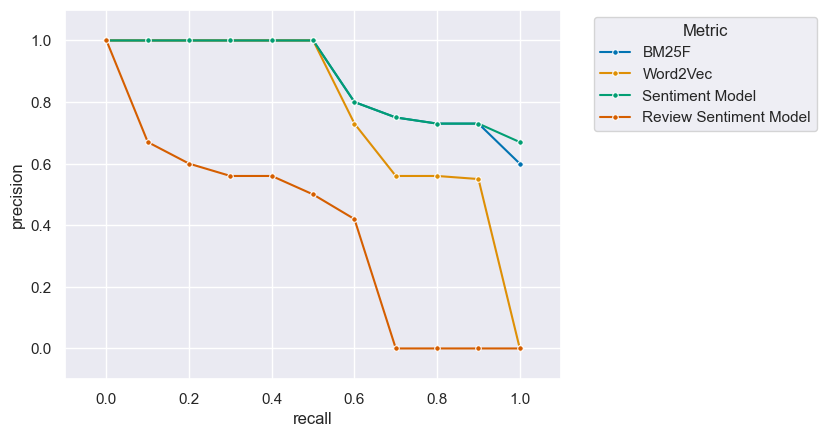

In [11]:
# define axes' names
axes = ["recall", "precision"]

# create a dataframe for Seaborn
df = pd.DataFrame()
for model, model_name in models:
    result = b.get_results(20, model)
    # get precision at standard recall values over list of result
    SRLValues = b.get_srl_values(
        b.get_precision_values(result),
        b.get_recall_values(result)
    )
    
    # tmp dataframe concatenated to the main one
    dfB = pd.DataFrame(SRLValues, columns = axes)
    dfB["Version"] = f'{model_name}'
    
    df = pd.concat([df, dfB])

sns.set_theme()


# plot the line graph
pltP = sns.lineplot(data = df, x = 'recall', y = 'precision', marker='o', markersize=4, hue="Version", palette="colorblind")
pltP.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')

# set fixed axes, the semicolon suppress the output
pltP.set_xlim([-0.1, 1.1]);
pltP.set_ylim([-0.1, 1.1]);

print(b)

### Average Precision At Standard Recall Levels

The precision at standard recall levels is calculated as in the previous example, but this time not for a single query but for all of them.

In [12]:
IAPatSRL = {}

for q in queries:
    tmpB = Benchmark(q)
    for model, model_name in models:
        result = tmpB.get_results(20, model)
        SRLValues = tmpB.get_srl_values(
            tmpB.get_precision_values(result),
            tmpB.get_recall_values(result)
            )
        IAPatSRL.setdefault(model_name, []).append(
			SRLValues
		)


Subsequently, the average precision is calculated for each recall level.

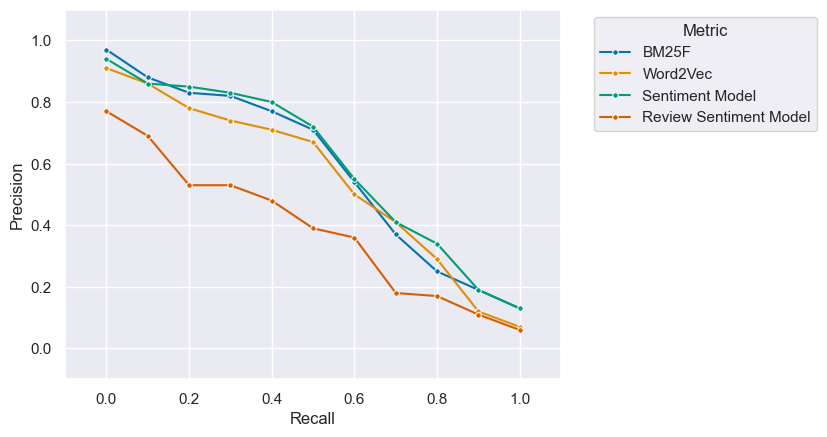

In [13]:
from functools import reduce
import matplotlib as plt
meansDict = {}

for k,v in IAPatSRL.items():
    # Trasporre la lista di liste per ottenere gli elementi corrispondenti
    transposed = list(zip(*v))

    # Calcolare la media dei secondi elementi delle tuple utilizzando reduce
    means = []
    for tuples in transposed:
        mean = reduce(lambda acc, t: acc + t[1], tuples, 0) / len(tuples)
        means.append((tuples[0][0], round(mean,2)))
    
    meansDict[k] = means


# Convert the dictionary to a DataFrame
df_list = []

for key, value in meansDict.items():
    for x, y in value:
        df_list.append({'Version': key, 'Recall': x, 'Precision': y})

df = pd.DataFrame(df_list)

# Plotting with Seaborn
pltIAPatSRL = sns.lineplot(data=df, x='Recall', y='Precision', hue='Version', marker='o', markersize=4, palette="colorblind")
pltIAPatSRL.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left');

pltIAPatSRL.set_xlim([-0.1, 1.1]);
pltIAPatSRL.set_ylim([-0.1, 1.1]);


### Interpolated Average Precision (IAP) at Standard Recall Levels for query Q

Interpolated Average Precision for each query is computed using 

$\sum_{r=0}^{n} \frac{P_q(r)}{n}$

where $P_q(r)$ is the interpolated precision at the level $r$, for n+1 standard recall levels.

UIN: I want to cook some delicious blueberries muffins
Query: (delicious blueberry muffins) AND n_steps:[1 TO 50] AND prep_time:[1 TO 300] AND n_ingredients:[1 TO 20] AND recipe_date:[2000-01-01 TO 2024-12-31]
Sentiments: ['joy']
Relevant documents: [371970, 13923, 214088, 98985, 78892, 86105, 166025, 290078, 65163, 170250, 90135, 375810] 


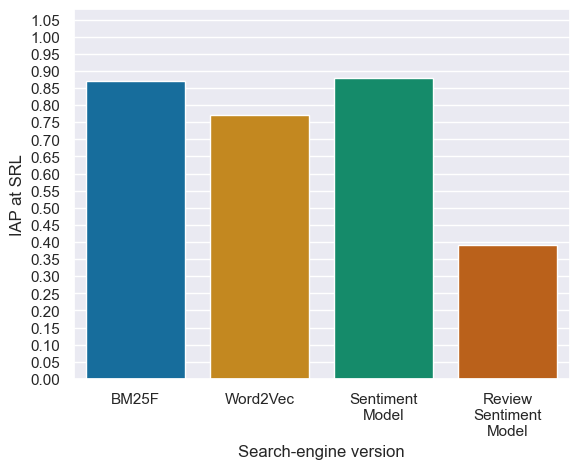

In [14]:
from matplotlib.ticker import MultipleLocator
import textwrap

versions = [] 
AvPr_values=[]

for model, model_name in models:
    result = b.get_results(20, model)
    SRLValues = b.get_srl_values(
        b.get_precision_values(result),
        b.get_recall_values(result)
    )
    
    AvPr_values.append(b.get_i_ap_avg_precision(SRLValues))
    versions.append(textwrap.fill(model_name, width=10,
                    break_long_words=True))
    
# plot the average precisions
# apply the default theme
sns.set_theme()


# create a dataframe for Seaborn
df = pd.DataFrame({"Search-engine version": versions, "IAP at SRL": AvPr_values})

# plot the bar graph
pltAvPr = sns.barplot(data = df, x = "Search-engine version", y = 'IAP at SRL',palette="colorblind")


# set fixed axes, the semicolon suppress the output
pltAvPr.set_ylim([0.0, max(AvPr_values)+0.20]); # set y-axis    
pltAvPr.yaxis.set_major_locator(MultipleLocator(0.05))

print(b)

### R-Precision for query Q

Calculate how many relevant documents I have returned compared to the ideal case in which in the first $n$ documents are all relevants. 

UIN: I want to cook some delicious blueberries muffins
Query: (delicious blueberry muffins) AND n_steps:[1 TO 50] AND prep_time:[1 TO 300] AND n_ingredients:[1 TO 20] AND recipe_date:[2000-01-01 TO 2024-12-31]
Sentiments: ['joy']
Relevant documents: [371970, 13923, 214088, 98985, 78892, 86105, 166025, 290078, 65163, 170250, 90135, 375810] 


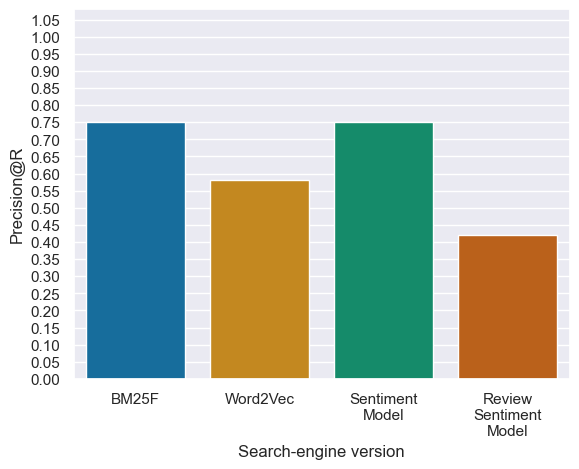

In [15]:
versions = [] 
RP_values=[]

for model, model_name in models:
    result = b.get_results(20, model)
    
    RP_values.append(b.get_r_precision(result))
    
    versions.append(textwrap.fill(model_name, width=10,
                break_long_words=True))

# plot the average precisi+ons
# apply the default theme
sns.set_theme()

# create a dataframe for Seaborn
df = pd.DataFrame({"Search-engine version": versions, 'Precision@R': RP_values})

# plot the bar graph
pltRP = sns.barplot(data = df, x = "Search-engine version", y = 'Precision@R', palette="colorblind")

# set fixed axes, the semicolon suppress the output
pltRP.set_ylim([0.0, max(AvPr_values)+0.20]); # set y-axis    
pltRP.yaxis.set_major_locator(MultipleLocator(0.05))

print(b)

### R-Precision Comparison between two models

Models selection occurs by assigning a value to the two dedicated variables from the available models.

In [16]:
'''
Available models: 
- "BM25F"
- "Word2Vec"
- "Sentiment Model"
- "Review Sentiment Model"
'''

model1 = "Sentiment Model"
model2 = "Review Sentiment Model"

for model, model_name in models:
    if model1 == model_name:
        model1 = (model, model_name)
    if model2 == model_name:
        model2 =(model, model_name)

Compute the R-Precision for both models and for each query. Subsequently, save the difference between them. 

This is the formula used:

$RP_{A/B}(i) =RP_{A}(i) -RP_{B}(i) $


In [17]:
RP_comparison = []
for q in queries:
    tmpB = Benchmark(q)
    model1Res = tmpB.get_results(20, model1[0])
    model2Res = tmpB.get_results(20, model2[0])
    
    RP_comparison.append(
        tmpB.get_r_precision(model1Res) - tmpB.get_r_precision(model2Res)
    )

A positive value indicates that *model A* has a higher *R_Precision* than *B* for that specific query, while a negative value indicates the opposite. This comparison provides an indication of which model is more effective in correctly ranking the primes $n$ relevant documents.


Plot the graph

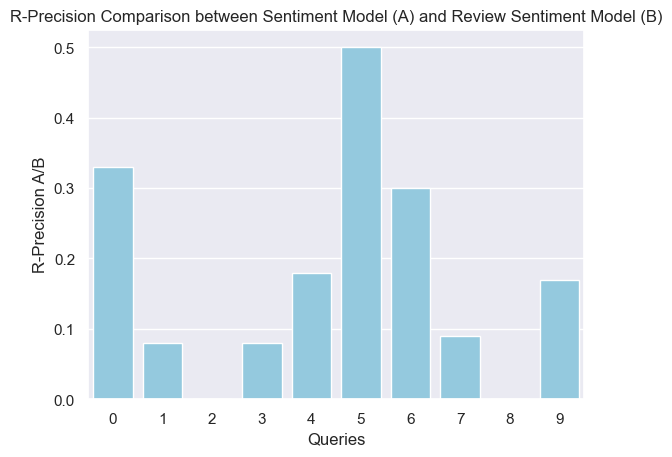

In [18]:
df = pd.DataFrame({
    'Queries': range(0, len(RP_comparison)),
    'R-Precision A/B': RP_comparison
})

pltRP_comp = sns.barplot(x='Queries', y='R-Precision A/B', data=df, color='skyblue')
pltRP_comp.set_title(f'R-Precision Comparison between {model1[1]} (A) and {model2[1]} (B)');



### Mean Average Precision (MAP)

Firstly, get Non-Interpolated Average Precision for each query using $ \sum_{r=0}^{n} \frac{P_q(r/|R_q|)}{|R_q|} $


Basically, it is an average where we sum only the precision (precision at natural level of recall) corresponding to the relevant documents since the recall does not change between a relevant document and a non-relevant document.

This measure favors systems that return documents relevant to the query q quickly, i.e. in the top positions.

In [19]:

NIAP_dict = {}

for q in queries:
    
    tmpB = Benchmark(q)
    
    for model, model_name in models:
        result = tmpB.get_results(20, model)
        NIAP_dict.setdefault(model_name, []).append(tmpB.get_ni_ap_avg_precision(
            tmpB.get_precision_values(result),
            tmpB.get_recall_values(result),
        ))


Secondly, compute Mean Average Precision for every model which is just an average between all the NIAP. 

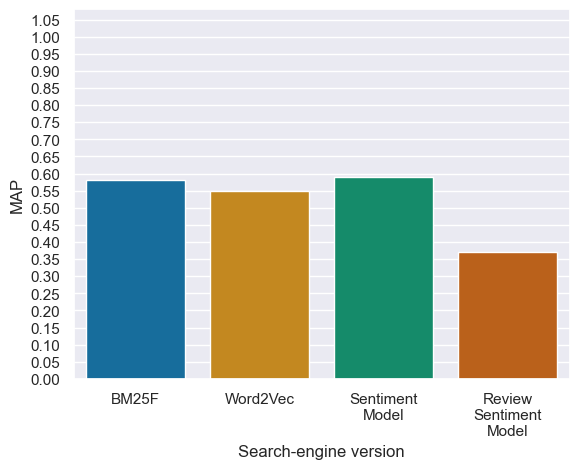

In [20]:
MAP_list = []
versions = []

for model_name, p_list in NIAP_dict.items():
    MAP_list.append(round(sum(p_list)/len(p_list),2) if len(p_list) != 0 else 0)
            
    versions.append(textwrap.fill(model_name, width=10,
                break_long_words=True))

# apply the default theme
sns.set_theme()

# create a dataframe for Seaborn
df = pd.DataFrame({"Search-engine version": versions, 'MAP': MAP_list})

# plot the bar graph
pltRP = sns.barplot(data = df, x = "Search-engine version", y = 'MAP', palette="colorblind")

# set fixed axes, the semicolon suppress the output
pltRP.set_ylim([0.0, max(AvPr_values)+0.20]); # set y-axis    
pltRP.yaxis.set_major_locator(MultipleLocator(0.05))


### F-Measure & E-Measure for query Q

F-Measure (or harmonic mean) is higher when both reacll and precision are high, there must be "harmony" between the two values. 

$$
\text{F-measure}=\frac{2}{\frac{1}{prec.}+\frac{1}{recall}}=\frac{2*prec.*recall}{prec.+recall}
$$

This metric combines precision and recall in order to obtain an unique value.

E-measure is a variant of the harmonic mean which allows us to emphasize the value of recall or precision based on what we are interested in.

$$
\text{E-measure}=1-\frac{1+b^2}{\frac{b^2}{recall}+\frac{1}{prec.}}
$$

In particular: 
- $b=1 \rightarrow 1-\text{F-Measure}$ 
- $b>1$ emphasize precision
- $b<1$ emphasize recall

*Precision or Recall?*

- High Recall: relevant documents, but with too many unrelevant documents. 
- High Precision: few results but with an greater probability of being relevant. 

It's possible to customize *b* value.

UIN: I want to cook some delicious blueberries muffins
Query: (delicious blueberry muffins) AND n_steps:[1 TO 50] AND prep_time:[1 TO 300] AND n_ingredients:[1 TO 20] AND recipe_date:[2000-01-01 TO 2024-12-31]
Sentiments: ['joy']
Relevant documents: [371970, 13923, 214088, 98985, 78892, 86105, 166025, 290078, 65163, 170250, 90135, 375810] 


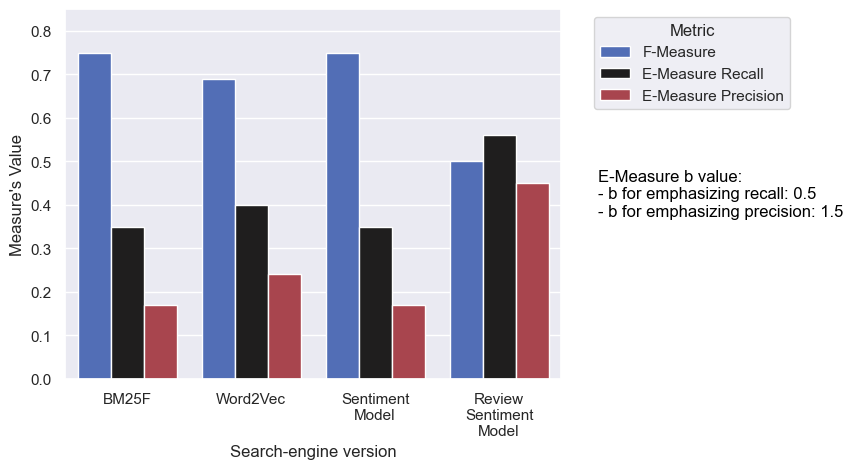

In [21]:

b_recall = 0.5          # Default value for emphasizing recall
b_precision = 1.5       # Default value for emphasizing precision

df = pd.DataFrame(columns=["Search-engine version"])
for model, model_name in models:    
    result = b.get_results(20, model)

    data = {
    'F-Measure': [b.get_f_measure(result)],
    'E-Measure Recall': [b.get_e_measure(result, b_recall)],
    'E-Measure Precision': [b.get_e_measure(result, b_precision)]
    }

    tmpDf = pd.DataFrame(data)
    tmpDf["Search-engine version"] = textwrap.fill(model_name, width=10,
                break_long_words=True)
    
    df = pd.concat([df, tmpDf])
    

# apply the default theme
sns.set_theme()

df_long = df.melt(id_vars='Search-engine version', var_name='Metric', value_name='Measure\'s Value')

# Crea il barplot
pltMeasures = sns.barplot(x='Search-engine version', y='Measure\'s Value', hue='Metric', data=df_long, palette='icefire')
pltMeasures.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')


# set fixed axes, the semicolon suppress the output
pltMeasures.set_ylim([0.0, df.iloc[:, -3:].max().max()+0.1]); # set y-axis   

infolabel = f'E-Measure b value:\n- b for emphasizing recall: {b_recall} \n- b for emphasizing precision: {b_precision}'
pltMeasures.text(x=pltMeasures.get_xlim()[1] + 0.3, y=(pltMeasures.get_ylim()[0] + pltMeasures.get_ylim()[1]) / 2, s=infolabel, fontsize=12, color='black', ha='left', va='center', rotation=0);

print(b)